In [1]:
import torch
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return avg_out * x + max_out * x

class VGGNet(nn.Module):
    def __init__(self, block=nn.Conv2d):
        super(VGGNet, self).__init__()

        self.relu = nn.LeakyReLU(0.01)

        # RGB branch
        self.conv1_rgb = block(3, 8, kernel_size=3, padding=1)
        self.bn1_rgb = nn.BatchNorm2d(8)
        self.conv2_rgb = block(8, 8, kernel_size=3, padding=1)
        self.bn2_rgb = nn.BatchNorm2d(8)
        self.max_pool1_rgb = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_rgb = block(8, 16, kernel_size=3, padding=1)
        self.bn3_rgb = nn.BatchNorm2d(16)
        self.conv4_rgb = block(16, 16, kernel_size=3, padding=1)
        self.bn4_rgb = nn.BatchNorm2d(16)
        self.ca_rgb3 = ChannelAttention(16)
        self.max_pool2_rgb = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_rgb = block(16, 32, kernel_size=3, padding=1)
        self.bn5_rgb = nn.BatchNorm2d(32)
        self.conv6_rgb = block(32, 32, kernel_size=3, padding=1)
        self.bn6_rgb = nn.BatchNorm2d(32)
        self.ca_rgb5 = ChannelAttention(32)
        self.max_pool3_rgb = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7_rgb = block(32, 64, kernel_size=3, padding=1)
        self.bn7_rgb = nn.BatchNorm2d(64)
        self.conv8_rgb = block(64, 64, kernel_size=3, padding=1)
        self.bn8_rgb = nn.BatchNorm2d(64)
        self.max_pool4_rgb = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv9_rgb = block(64, 128, kernel_size=3, padding=1)
        self.bn9_rgb = nn.BatchNorm2d(128)
        self.conv10_rgb = block(128, 128, kernel_size=3, padding=1)
        self.bn10_rgb = nn.BatchNorm2d(128)
        self.max_pool5_rgb = nn.MaxPool2d(kernel_size=2, stride=2)

        # Grayscale branch
        self.conv1_L = block(1, 8, kernel_size=3, padding=1)
        self.bn1_L = nn.BatchNorm2d(8)
        self.conv2_L = block(8, 8, kernel_size=3, padding=1)
        self.bn2_L = nn.BatchNorm2d(8)
        self.max_pool1_L = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_L = block(8, 16, kernel_size=3, padding=1)
        self.bn3_L = nn.BatchNorm2d(16)
        self.conv4_L = block(16, 16, kernel_size=3, padding=1)
        self.bn4_L = nn.BatchNorm2d(16)
        self.ca_L2 = ChannelAttention(16)
        self.max_pool2_L = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_L = block(16, 32, kernel_size=3, padding=1)
        self.bn5_L = nn.BatchNorm2d(32)
        self.conv6_L = block(32, 32, kernel_size=3, padding=1)
        self.bn6_L = nn.BatchNorm2d(32)
        self.ca_L3 = ChannelAttention(32)
        self.max_pool3_L = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7_L = block(32, 64, kernel_size=3, padding=1)
        self.bn7_L = nn.BatchNorm2d(64)
        self.conv8_L = block(64, 64, kernel_size=3, padding=1)
        self.bn8_L = nn.BatchNorm2d(64)
        self.max_pool4_L = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv9_L = block(64, 128, kernel_size=3, padding=1)
        self.bn9_L = nn.BatchNorm2d(128)
        self.conv10_L = block(128, 128, kernel_size=3, padding=1)
        self.bn10_L = nn.BatchNorm2d(128)
        self.max_pool5_L = nn.MaxPool2d(kernel_size=2, stride=2)

        # Upsampling layer
        self.up1 = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.up2 = torch.nn.Upsample(scale_factor=4, mode='bilinear')
        self.up3 = torch.nn.Upsample(scale_factor=8, mode='bilinear')
        self.up4 = torch.nn.Upsample(scale_factor=16, mode='bilinear')

        # Channel Attention modules
#         self.ca_rgb = ChannelAttention(256-8)
#         self.ca_L = ChannelAttention(256-8)
        self.conv_fus_rgb = block(224, 32, kernel_size=1)
        self.bn_fus_rgb = nn.BatchNorm2d(32)
        self.conv_fus_L = block(224, 32, kernel_size=1)
        self.bn_fus_L = nn.BatchNorm2d(32)
        self.conv_fus_all = block(64, 16, kernel_size=1)
        self.bn_fus_all = nn.BatchNorm2d(16)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(50176, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.01),
            nn.Linear(64, 6),
            nn.Sigmoid()
        )

    def forward(self, rgb, L):
        # RGB branch
        x_rgb1 = self.relu(self.conv1_rgb(rgb))
        x_rgb1 = self.bn1_rgb(x_rgb1)
        x_rgb1 = self.relu(self.conv2_rgb(x_rgb1))
        x_rgb1 = self.bn2_rgb(x_rgb1)
        x_rgb1 = self.max_pool1_rgb(x_rgb1)

        x_rgb2 = self.relu(self.conv3_rgb(x_rgb1))
        x_rgb2 = self.bn3_rgb(x_rgb2)
        x_rgb2 = self.relu(self.conv4_rgb(x_rgb2))
        x_rgb2 = self.bn4_rgb(x_rgb2)
        x_rgb2 = self.max_pool2_rgb(x_rgb2)

        x_rgb3 = self.relu(self.conv5_rgb(x_rgb2))
        x_rgb3 = self.bn5_rgb(x_rgb3)
        x_rgb3 = self.relu(self.conv6_rgb(x_rgb3))
        x_rgb3 = self.bn6_rgb(x_rgb3)
        x_rgb3 = self.max_pool3_rgb(x_rgb3)

        x_rgb4 = self.relu(self.conv7_rgb(x_rgb3))
        x_rgb4 = self.bn7_rgb(x_rgb4)
        x_rgb4 = self.relu(self.conv8_rgb(x_rgb4))
        x_rgb4 = self.bn8_rgb(x_rgb4)
        x_rgb4 = self.max_pool4_rgb(x_rgb4)

        x_rgb5 = self.relu(self.conv9_rgb(x_rgb4))
        x_rgb5 = self.bn9_rgb(x_rgb5)
        x_rgb5 = self.relu(self.conv10_rgb(x_rgb5))
        x_rgb5 = self.bn10_rgb(x_rgb5)
        x_rgb5 = self.max_pool5_rgb(x_rgb5)

        # Grayscale branch
        x_L1 = self.relu(self.conv1_L(L))
        x_L1 = self.bn1_L(x_L1)
        x_L1 = self.relu(self.conv2_L(x_L1))
        x_L1 = self.bn2_L(x_L1)
        x_L1 = self.max_pool1_L(x_L1)

        x_L2 = self.relu(self.conv3_L(x_L1))
        x_L2 = self.bn3_L(x_L2)
        x_L2 = self.relu(self.conv4_L(x_L2))
        x_L2 = self.bn4_L(x_L2)
        x_L2 = self.max_pool2_L(x_L2)

        x_L3 = self.relu(self.conv5_L(x_L2))
        x_L3 = self.bn5_L(x_L3)
        x_L3 = self.relu(self.conv6_L(x_L3))
        x_L3 = self.bn6_L(x_L3)
        x_L3 = self.max_pool3_L(x_L3)

        x_L4 = self.relu(self.conv7_L(x_L3))
        x_L4 = self.bn7_L(x_L4)
        x_L4 = self.relu(self.conv8_L(x_L4))
        x_L4 = self.bn8_L(x_L4)
        x_L4 = self.max_pool4_L(x_L4)

        x_L5 = self.relu(self.conv9_L(x_L4))
        x_L5 = self.bn9_L(x_L5)
        x_L5 = self.relu(self.conv10_L(x_L5))
        x_L5 = self.bn10_L(x_L5)
        x_L5 = self.max_pool5_L(x_L5)
        x_rgb5 = self.up3(x_rgb5)
        x_rgb4 = self.up2(x_rgb4)
        x_rgb3 = self.up1(x_rgb3)
        x_L5 = self.up3(x_L5)
        x_L4 = self.up2(x_L4)
        x_L3 = self.up1(x_L3)

        # Concatenate RGB branches
        x_rgb_concat = torch.cat(( x_rgb3, x_rgb4, x_rgb5), dim=1)
        x_rgb_concat = self.conv_fus_rgb(x_rgb_concat)
        x_rgb_concat = self.bn_fus_rgb(x_rgb_concat)
        # Concatenate Grayscale branches
        x_L_concat = torch.cat(( x_L3, x_L4, x_L5), dim=1)
        x_L_concat = self.conv_fus_L(x_L_concat)
        x_L_concat = self.bn_fus_L(x_L_concat)

        # Apply attention
#         x_rgb_att = self.ca_rgb(x_rgb_concat)
#         x_L_att = self.ca_L(x_L_concat)

        # Concatenate attention outputs
        x_combined = torch.cat((x_rgb_concat, x_L_concat), dim=1)
        x_combined = self.conv_fus_all(x_combined)
        x_combined = self.bn_fus_all(x_combined)
        # Fully connected layers
        x_fc = self.fc(x_combined)

        return x_fc

# Instantiate the model
model = VGGNet()
print(model)

VGGNet(
  (relu): LeakyReLU(negative_slope=0.01)
  (conv1_rgb): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_rgb): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_rgb): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_rgb): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool1_rgb): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_rgb): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3_rgb): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_rgb): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4_rgb): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ca_rgb3): ChannelAttention(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (fc): Sequential(
      (0): Conv2d

In [2]:
import numpy as np
train0 = np.load('augmented_new16sample_data_all.npy',allow_pickle=True)
train0g = np.load('augmented_new16sample_datag_all.npy',allow_pickle=True)
label0 = np.load('augmented_new16sample_label_all.npy',allow_pickle=True)
train0 = np.transpose(train0, (0, 3, 1, 2))
# train0g = np.transpose(train0g, (0, 3, 1, 2))
train0g = np.expand_dims(train0g, axis=1)

C:\Users\Brea-RD\AppData\Local\Temp/ipykernel_31900/3883609465.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.d

[ 0  1  9 10 13 23 27 28 29 30 35 36 41 44 46 47 51 52 53]
Epoch [1/70], Train Loss: 0.3371, Train Acc: 87.63%, Val Loss: 0.4349, Val Acc: 93.16%
Epoch [2/70], Train Loss: 0.1249, Train Acc: 93.82%, Val Loss: 0.4707, Val Acc: 95.00%
Epoch [3/70], Train Loss: 0.0734, Train Acc: 96.18%, Val Loss: 0.4676, Val Acc: 94.74%
Epoch [4/70], Train Loss: 0.0473, Train Acc: 97.37%, Val Loss: 0.4027, Val Acc: 98.16%
Epoch [5/70], Train Loss: 0.0304, Train Acc: 98.95%, Val Loss: 0.4694, Val Acc: 95.26%
Epoch [6/70], Train Loss: 0.0253, Train Acc: 98.29%, Val Loss: 0.4031, Val Acc: 97.63%
Epoch [7/70], Train Loss: 0.0276, Train Acc: 99.21%, Val Loss: 0.3749, Val Acc: 96.58%
Epoch [8/70], Train Loss: 0.0259, Train Acc: 97.89%, Val Loss: 0.5030, Val Acc: 95.26%
Epoch [9/70], Train Loss: 0.0163, Train Acc: 99.21%, Val Loss: 0.3751, Val Acc: 97.37%
Epoch [10/70], Train Loss: 0.0230, Train Acc: 98.55%, Val Loss: 0.4362, Val Acc: 95.53%
Epoch [11/70], Train Loss: 0.0116, Train Acc: 99.34%, Val Loss: 0.4193

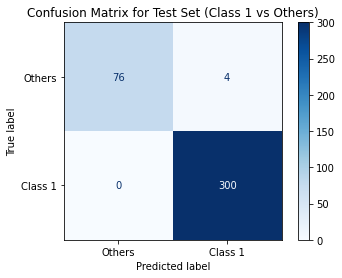

C:\Users\Brea-RD\AppData\Local\Temp/ipykernel_31900/3883609465.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.d

[ 2  4  5  6 12 14 16 17 19 24 25 32 33 38 39 42 48 50 55]
Epoch [1/70], Train Loss: 0.5063, Train Acc: 74.87%, Val Loss: 0.6181, Val Acc: 82.37%
Epoch [2/70], Train Loss: 0.2334, Train Acc: 84.47%, Val Loss: 0.4819, Val Acc: 92.89%
Epoch [3/70], Train Loss: 0.1223, Train Acc: 92.24%, Val Loss: 0.3437, Val Acc: 98.42%
Epoch [4/70], Train Loss: 0.1273, Train Acc: 91.32%, Val Loss: 0.2776, Val Acc: 98.95%
Epoch [5/70], Train Loss: 0.0906, Train Acc: 94.74%, Val Loss: 0.5417, Val Acc: 95.53%
Epoch [6/70], Train Loss: 0.0799, Train Acc: 95.66%, Val Loss: 0.2802, Val Acc: 98.16%
Epoch [7/70], Train Loss: 0.0620, Train Acc: 95.92%, Val Loss: 0.2267, Val Acc: 96.32%
Epoch [8/70], Train Loss: 0.0865, Train Acc: 95.66%, Val Loss: 0.3460, Val Acc: 95.00%
Epoch [9/70], Train Loss: 0.0825, Train Acc: 95.53%, Val Loss: 0.2113, Val Acc: 99.21%
Epoch [10/70], Train Loss: 0.1030, Train Acc: 93.95%, Val Loss: 0.4622, Val Acc: 97.11%
Epoch [11/70], Train Loss: 0.0772, Train Acc: 96.45%, Val Loss: 0.2276

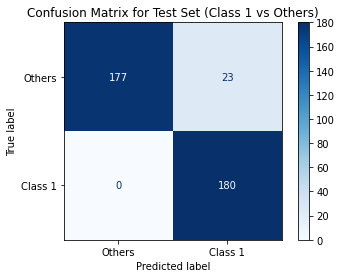

C:\Users\Brea-RD\AppData\Local\Temp/ipykernel_31900/3883609465.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.d

[ 3  7  8 11 15 18 20 21 22 26 31 34 37 40 43 45 49 54 56]
Epoch [1/70], Train Loss: 0.4529, Train Acc: 85.39%, Val Loss: 0.1360, Val Acc: 89.47%
Epoch [2/70], Train Loss: 0.1288, Train Acc: 93.55%, Val Loss: 0.0574, Val Acc: 93.42%
Epoch [3/70], Train Loss: 0.0710, Train Acc: 96.45%, Val Loss: 0.0318, Val Acc: 96.84%
Epoch [4/70], Train Loss: 0.0770, Train Acc: 96.05%, Val Loss: 0.0561, Val Acc: 94.47%
Epoch [5/70], Train Loss: 0.0869, Train Acc: 95.13%, Val Loss: 0.0148, Val Acc: 99.47%
Epoch [6/70], Train Loss: 0.0716, Train Acc: 96.58%, Val Loss: 0.0148, Val Acc: 99.74%
Epoch [7/70], Train Loss: 0.0663, Train Acc: 95.79%, Val Loss: 0.0113, Val Acc: 100.00%
Epoch [8/70], Train Loss: 0.0363, Train Acc: 98.42%, Val Loss: 0.0109, Val Acc: 100.00%
Epoch [9/70], Train Loss: 0.0489, Train Acc: 98.68%, Val Loss: 0.0172, Val Acc: 99.47%
Epoch [10/70], Train Loss: 0.0465, Train Acc: 96.84%, Val Loss: 0.0348, Val Acc: 97.11%
Epoch [11/70], Train Loss: 0.0199, Train Acc: 98.55%, Val Loss: 0.00

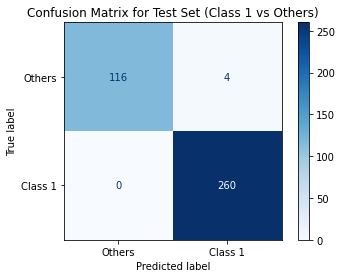

In [3]:
#augmentation training
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, ToTensor
import torchvision.transforms as transforms
from torch.optim import Adam
import cv2
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from torch.utils.tensorboard import SummaryWriter

data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=3, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=3),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
])
class CustomDataset(Dataset):
    def __init__(self, data, L, labels, transform=None):
        self.data = torch.Tensor(data)
        self.L = torch.Tensor(L)
        self.labels = torch.Tensor(labels)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        L = self.L[idx]
        if self.transform:
            self.image = self.transform(image)
        return (image, L, self.labels[idx])




import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def train_model(model, train_loader, test_loader, lr=1e-4, epochs=70, device='cuda'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for rgb_data, L, labels in train_loader:
            rgb_data, L, labels = rgb_data.to(device), L.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(rgb_data, L)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            predicted = (outputs >= 0.5).squeeze(1)[:, 0]
            correct += predicted.eq(labels[:, 0].byte()).sum().item()
            total += labels.size(0)

        train_loss_history.append(train_loss / len(train_loader))
        train_acc_history.append(correct / total)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for rgb_data, L, labels in test_loader:
                rgb_data, L, labels = rgb_data.to(device), L.to(device), labels.to(device)

                outputs = model(rgb_data, L)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                predicted = (outputs >= 0.5).squeeze(1)[:, 0]
                correct += predicted.eq(labels[:, 0].byte()).sum().item()
                total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels[:, 0].cpu().numpy())

        val_loss_history.append(val_loss / len(test_loader))
        val_acc_history.append(correct / total)

        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_history[-1]:.4f}, Train Acc: {train_acc_history[-1]*100:.2f}%, Val Loss: {val_loss_history[-1]:.4f}, Val Acc: {val_acc_history[-1]*100:.2f}%')

    # Create binary labels for the first class vs others
    binary_preds = [1 if p == 1 else 0 for p in all_preds]
    binary_labels = [1 if l == 1 else 0 for l in all_labels]

    # Compute and plot the 2x2 confusion matrix
    cm = confusion_matrix(binary_labels, binary_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Others', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Test Set (Class 1 vs Others)')
    plt.show()

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# Assuming your data and labels are numpy arrays
N = 3
kf = KFold(n_splits=N, shuffle=True, random_state=2)

fold_metrics = np.zeros((N, 4, 70))  # To store metrics for each fold
# Convert data and labels to PyTorch tensors or datasets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Perform 5-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(range(57))):


        # Initialize model
    model = VGGNet().to(device)

    model_path = 'signal_gray_bn_attention2_6class_rgbtrans_cropout_0.pt'
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    mask = np.isin(label0[:, -1], train_index)
    label0_train = label0[:, :-1]
    lr = 1e-4
    dataset = CustomDataset(train0, train0g, label0_train)
    train_sample = np.array(range(1140))[mask]
    test_sample = np.array(range(1140))[~mask]
    train_dataset = torch.utils.data.Subset(dataset, train_sample)
    test_dataset = torch.utils.data.Subset(dataset, test_sample)
    print(test_index)

    train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False)
    # Training the model
    train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, train_loader, test_loader, lr=lr, epochs=70, device=device)

    # Save model if needed
    save_path = f'newsamples_6class_aug_strans_moregood_{fold}.pt'
    torch.save(model.state_dict(), save_path)

    # Clear memory
    del model
    torch.cuda.empty_cache()